In [2]:
#首先，将数据以dataframe的形式导入python
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
fec = pd.read_csv('F:/fec/P00000001-All.csv')
fec.info()

C:\Users\Administrator\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001731 entries, 0 to 1001730
Data columns (total 16 columns):
cmte_id              1001731 non-null object
cand_id              1001731 non-null object
cand_nm              1001731 non-null object
contbr_nm            1001731 non-null object
contbr_city          1001712 non-null object
contbr_st            1001727 non-null object
contbr_zip           1001620 non-null object
contbr_employer      988002 non-null object
contbr_occupation    993301 non-null object
contb_receipt_amt    1001731 non-null float64
contb_receipt_dt     1001731 non-null object
receipt_desc         14166 non-null object
memo_cd              92482 non-null object
memo_text            97770 non-null object
form_tp              1001731 non-null object
file_num             1001731 non-null int64
dtypes: float64(1), int64(1), object(14)
memory usage: 122.3+ MB


In [5]:
#首先以occupation和employer为着力点，分析数据
unique_cands = fec.cand_nm.unique() #首先明确候选人名单; series.unique()以array形式，返回unique_value；
unique_cands

array(['Bachmann, Michelle', 'Romney, Mitt', 'Obama, Barack',
       "Roemer, Charles E. 'Buddy' III", 'Pawlenty, Timothy',
       'Johnson, Gary Earl', 'Paul, Ron', 'Santorum, Rick', 'Cain, Herman',
       'Gingrich, Newt', 'McCotter, Thaddeus G', 'Huntsman, Jon',
       'Perry, Rick'], dtype=object)

In [7]:
#将每个候选人所依附的党派信息加入fec dataframe
#以Mapping的形式处理
parties = {'Bachmann, Michelle':'Republican',
          'Cain, Herman':'Republican',
          'Gingrich, Newt':'Republican',
          'Huntsman, Jon':'Republican',
          'Johnson, Gary Earl':'Republican',
          'McCotter, Thaddeus G':'Republican',
          'Obama, Barack':'Democrat',
          'Paul, Ron':'Republican',
          'Perry, Rick':'Republican',
          "Roemer, Charles E. 'Buddy' III":'Republican',
          'Romney, Mitt':'Republican',
          'Santorum, Rick':'Republican',
          }
fec['party'] = fec.cand_nm.map(parties)
fec.party.value_counts() #计算各个党派在election中的人数

Democrat      593746
Republican    403430
Name: party, dtype: int64

In [10]:
#接下来，我们研究在这场精选中，贡献经费的情况，这里，不对撤资情况进行研究（即；贡献经费为负值）
#首先了解一下fund和refund在这场election中的数量
print((fec.contb_receipt_amt > 0).value_counts())
#将研究数据缩小为fund
fec_fund = fec[fec.contb_receipt_amt>0]
#由于OBamma和Mitt是两个主要的候选人，这里单另提取他们两个的数据,
fec_mrbo = fec[fec.cand_nm.isin(['Obama, Barack','Romney, Mitt'])]

True     991475
False     10256
Name: contb_receipt_amt, dtype: int64


In [13]:
#分析每种occupation和employer的捐赠情况
#首先看一下不同的occupation的捐赠人数
fec_fund.contbr_occupation.value_counts()[:5]

RETIRED                  233990
INFORMATION REQUESTED     35107
ATTORNEY                  34286
HOMEMAKER                 29931
PHYSICIAN                 23432
Name: contbr_occupation, dtype: int64

C:\Users\Administrator\Anaconda3\lib\site-packages\pandas\core\generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


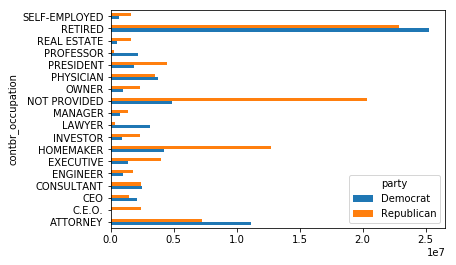

In [33]:
#由于occupation中一个职业有多种表达，或者一些表达没有实际意义，下面通过mapping，对occupation中的这些情况进行修正，使得同一种职业只有一种表达，
#或者，没有实际意义的occupation name用一些特定字符表示
occ_mapping = {'INFORMATION REQUESTED PER BEST EFFORTS':'NOT PROVIDED',
              'INFORMATION REQUESTED':'NOT PROVIDED',
              'INFORMATION REQUESTED (BEST EFFORTS)':'NOT PROVIDED',
              'C.E.O':'CEO'
              }
func = lambda x:occ_mapping.get(x,x)
fec_fund.contbr_occupation = fec_fund.contbr_occupation.map(func)

#对employer column也进行同样的处理
emp_mapping = {
    'INFORMATION REQUESTED PER BEST EFFORTS':'NOT PROVIDED',
    'INFORMATION REQUESTED':'NOT PROVIDED',
    'SELF':'SELF-EMPLOYED',
    'SELF EMPLOYED':'SELF-EMPLOYED'
}
func = lambda x:emp_mapping.get(x,x) #dictionary.get(x,default):如果x在dictionary中，返回其value，否则，返回default
fec_fund.contbr_employer = fec_fund.contbr_employer.map(func)

#处理好employer和occupation数据后，接下来，我们可以分析一下不同的occupation中republic和democrat各捐赠多少
by_occupation = fec_fund.pivot_table('contb_receipt_amt',index='contbr_occupation',columns='party',aggfunc='sum')
over_2mm = by_occupation[by_occupation.sum(1) > 2000000]
over_2mm.plot(kind='barh')
plt.show()

In [34]:
#给OBamma和Remnoy捐赠最多的occupation和company
#给两个candidate捐赠最多的职业top5
def get_top_amounts(group,key,n=5):
    totals = group.groupby(key).contb_receipt_amt.sum()
    return totals.nlargest(n)
grouped = fec_mrbo.groupby('cand_nm')
grouped.apply(get_top_amounts,'contbr_occupation',5) #返回应用函数的结果

cand_nm        contbr_occupation                     
Obama, Barack  RETIRED                                   25270507.23
               ATTORNEY                                  11126932.97
               INFORMATION REQUESTED                      4849801.96
               HOMEMAKER                                  4243394.30
               PHYSICIAN                                  3732387.44
Romney, Mitt   RETIRED                                   11266949.23
               INFORMATION REQUESTED PER BEST EFFORTS    11173374.84
               HOMEMAKER                                  8037250.86
               ATTORNEY                                   5302578.82
               PRESIDENT                                  2403439.77
Name: contb_receipt_amt, dtype: float64

In [35]:
#给出给两个候选人捐赠最多的employer
grouped.apply(get_top_amounts,'contbr_employer',5)

cand_nm        contbr_employer                       
Obama, Barack  RETIRED                                   22665902.20
               SELF-EMPLOYED                             17038455.96
               NOT EMPLOYED                               8584118.70
               INFORMATION REQUESTED                      5036178.37
               HOMEMAKER                                  2599987.04
Romney, Mitt   INFORMATION REQUESTED PER BEST EFFORTS    11827237.12
               RETIRED                                   11264701.35
               HOMEMAKER                                  8037000.86
               SELF-EMPLOYED                              7260882.29
               STUDENT                                     488642.82
Name: contb_receipt_amt, dtype: float64

In [39]:
#根据捐赠金额的多少将两位候选人的数据进行分割
import numpy as np
bins = np.array([1,10,100,1000,10000,100000,1000000,10000000])
labels = pd.cut(fec_mrbo.contb_receipt_amt,bins)
labels.head()

411      (10, 100]
412    (100, 1000]
413    (100, 1000]
414      (10, 100]
415      (10, 100]
Name: contb_receipt_amt, dtype: category
Categories (7, object): [(1, 10] < (10, 100] < (100, 1000] < (1000, 10000] < (10000, 100000] < (100000, 1000000] < (1000000, 10000000]]

In [44]:
#查看各个金额区间，给两位候选人捐赠的人数的多少
grouped = fec_mrbo.groupby(['cand_nm',labels])
grouped.size().unstack(0)

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(1, 10]",40070.0,3681.0
"(10, 100]",372280.0,31853.0
"(100, 1000]",153991.0,43357.0
"(1000, 10000]",22284.0,26186.0
"(10000, 100000]",2.0,1.0
"(100000, 1000000]",3.0,NaN
"(1000000, 10000000]",4.0,NaN


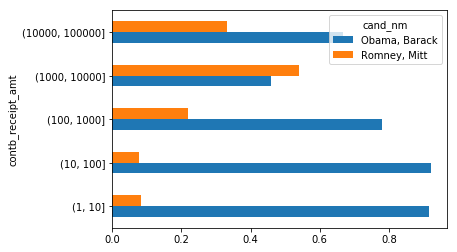

In [47]:
#求两位候选人在各个区间获得的支持百分比
bucket_sum = grouped.size().unstack(0).sum(1)
normed_sum = grouped.size().unstack(0).div(grouped.size().unstack(0).sum(1),axis=0)
normed_sum[:-2].plot(kind='barh')
plt.show()

In [55]:
#求各国给两位候选人的捐赠情况
totals = fec_mrbo.groupby(['cand_nm','contbr_st']).size().unstack(0).fillna(0)
print(totals.head(3))
#求捐赠总额>100000的国家
totals_100000 = totals[totals.sum(1)>100000]
print(totals_100000)
#求两位候选人获得各国金额的百分比
percent = totals.div(totals.sum(1),axis=0)
print(percent.head(3))
                                                                            

cand_nm    Obama, Barack  Romney, Mitt
contbr_st                             
AA                  78.0           2.0
AB                   4.0           0.0
AE                 395.0          16.0
cand_nm    Obama, Barack  Romney, Mitt
contbr_st                             
CA              101013.0       13595.0
cand_nm    Obama, Barack  Romney, Mitt
contbr_st                             
AA              0.975000      0.025000
AB              1.000000      0.000000
AE              0.961071      0.038929
